In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Softmax
import numpy as np

In [2]:
# Load VGG16 model pre-trained on ImageNet
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

Metal device set to: Apple M2


In [3]:
vgg16_base.load_weights('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/models/vgg_face_weights.h5', 
                        by_name=True)

In [4]:
# Freeze the convolutional base
for layer in vgg16_base.layers:
    layer.trainable = False

In [5]:
class TemperatureScaledSoftmax(tf.keras.layers.Layer):
    def __init__(self, temperature=1.0):
        super(TemperatureScaledSoftmax, self).__init__()
        self.temperature = temperature
        self.softmax = Softmax()

    def call(self, logits):
        scaled_logits = logits / self.temperature
        return self.softmax(scaled_logits)

In [6]:
# Add custom layers
x = layers.Flatten()(vgg16_base.output)  # Flatten the output from convolutional base
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout for regularization
x = layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)  # Another fully connected layer
x = layers.Dense(5, activation='softmax')(x)

#x = layers.Dense(5)(x)
#custome softmax layer
#x = TemperatureScaledSoftmax(temperature=1.5)(x)

# Define the new model
model = tf.keras.Model(inputs=vgg16_base.input, outputs=x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
model.compile(optimizer='adam', 
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import albumentations as A

In [10]:
df = pd.read_csv("/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Dataset/output_dataset.csv")

In [11]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(p=0.2),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2)
])


In [12]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['variety']= label_encoder.fit_transform(df['label'])
df

,image_id,label,variety
0,frame_567.jpg,S1252001,0
1,frame_413.jpg,S1252001,0
2,frame_406.jpg,S1252001,0
3,frame_360.jpg,S1252001,0
4,frame_570.jpg,S1252001,0
...,...,...,...
457,frame_609.jpg,S1252002,1
458,frame_350.jpg,S1252002,1
459,frame_378.jpg,S1252002,1
460,frame_581.jpg,S1252002,1


In [13]:
df = df.sort_values('variety')
df

,image_id,label,variety
0,frame_567.jpg,S1252001,0
62,frame_469.jpg,S1252001,0
61,frame_441.jpg,S1252001,0
60,frame_455.jpg,S1252001,0
59,frame_497.jpg,S1252001,0
...,...,...,...
148,frame_546.jpg,S1252050,4
149,frame_180.jpg,S1252050,4
150,frame_427.jpg,S1252050,4
129,frame_322.jpg,S1252050,4


In [14]:
a=df["label"].unique()
a

array(['S1252001', 'S1252002', 'S1252003', 'S1252004', 'S1252050'],
      dtype=object)

In [15]:
df["variety"].unique()

array([0, 1, 2, 3, 4])

In [16]:
obj={"img":[], "label":[],"variety":[]}
for i in range(len(df)):
    path = os.path.join("/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Dataset/output_dataset", df["label"][i])
    path = os.path.join(path, df["image_id"][i])
    try:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        
        obj["img"].append(img)
        obj["label"].append(df["label"][i])
        obj["variety"].append(df["variety"][i])
        
        #img = cv2.resize(img, (1080, 1080), interpolation=cv2.INTER_AREA)
        #img = face_crop(img, path)
        
        #if img:
            #obj["img"].append(img)
            #obj["label"].append(df["label"][i])
            #obj["variety"].append(df["variety"][i])
    except:
        continue

In [17]:
def agu(img):
    return transform(image=img)["image"]
for i in range(len(obj["img"])):
    obj["img"].append(agu(obj["img"][i]))
    obj["label"].append(obj["label"][i])
    obj["variety"].append(obj["variety"][i])
    


In [18]:
len(obj["label"])

924

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val,Y_train, Y_val = train_test_split(obj["img"], obj['variety'],test_size=0.2,random_state=42)

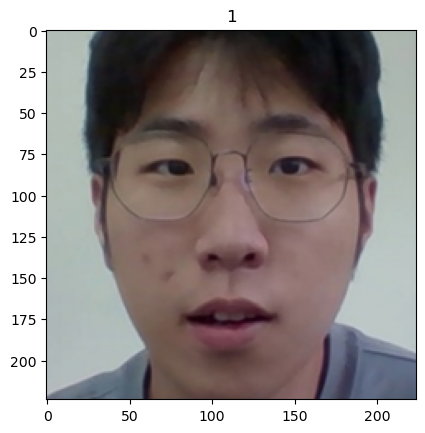

In [20]:
plt.imshow(X_train[522])
plt.title(Y_train[522])
plt.show()

In [21]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [22]:
from keras.callbacks import Callback

class BatchMetricsCallback(Callback):
    def on_train_begin(self, logs=None):
        self.batch_accuracies = []
        self.batch_losses = []
        self.validation_accuracies = []
        self.validation_losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_accuracies.append(logs.get('accuracy'))
        self.batch_losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs=None):
        self.validation_accuracies.append(logs.get('val_accuracy'))
        self.validation_losses.append(logs.get('val_loss'))

# Instantiate the callback
batch_metrics_callback = BatchMetricsCallback()

In [23]:
ret= model.fit(x=X_train,y=Y_train, epochs=10, batch_size=20, verbose=1, validation_split=0.2, callbacks=[batch_metrics_callback])

Epoch 1/10


2024-07-09 14:38:12.111915: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 [==============================] - 11s 356ms/step - loss: 5.8469 - accuracy: 0.3587 - val_loss: 4.0768 - val_accuracy: 0.4324
Epoch 2/10
30/30 [==============================] - 10s 350ms/step - loss: 3.2377 - accuracy: 0.5076 - val_loss: 2.7833 - val_accuracy: 0.5068
Epoch 3/10
30/30 [==============================] - 10s 348ms/step - loss: 2.4686 - accuracy: 0.5973 - val_loss: 2.1959 - val_accuracy: 0.6486
Epoch 4/10
30/30 [==============================] - 10s 348ms/step - loss: 1.8833 - accuracy: 0.7124 - val_loss: 1.7182 - val_accuracy: 0.7703
Epoch 5/10
30/30 [==============================] - 10s 347ms/step - loss: 1.6969 - accuracy: 0.7191 - val_loss: 1.4110 - val_accuracy: 0.8311
Epoch 6/10
30/30 [==============================] - 10s 347ms/step - loss: 1.4632 - accuracy: 0.7885 - val_loss: 1.3715 - val_accuracy: 0.8446
Epoch 7/10
30/30 [==============================] - 10s 347ms/step - loss: 1.4064 - accuracy: 0.7783 - val_loss: 1.5821 - val_accuracy: 0.6351
Epoch 8/10

In [24]:
# Extract the metrics from the callback of Dense Layer Training
batch_accuracies_dense = batch_metrics_callback.batch_accuracies
batch_losses_dense = batch_metrics_callback.batch_losses
validation_accuracies_dense = batch_metrics_callback.validation_accuracies
validation_losses_dense = batch_metrics_callback.validation_losses

In [25]:
# Unfreeze Convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = True


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Compile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
fine_tune_fit = model.fit(x=X_train,y=Y_train, epochs=10, batch_size=20, verbose=1, validation_split=0.2, callbacks=[batch_metrics_callback])

Epoch 1/10
30/30 [==============================] - 31s 1s/step - loss: 1.0363 - accuracy: 0.8579 - val_loss: 0.9273 - val_accuracy: 0.8716
Epoch 2/10
30/30 [==============================] - 30s 987ms/step - loss: 0.8791 - accuracy: 0.9205 - val_loss: 0.8441 - val_accuracy: 0.9122
Epoch 3/10
30/30 [==============================] - 30s 984ms/step - loss: 0.8595 - accuracy: 0.9306 - val_loss: 0.8009 - val_accuracy: 0.9189
Epoch 4/10
30/30 [==============================] - 30s 993ms/step - loss: 0.7925 - accuracy: 0.9425 - val_loss: 0.8601 - val_accuracy: 0.9122
Epoch 5/10
30/30 [==============================] - 30s 990ms/step - loss: 0.7817 - accuracy: 0.9509 - val_loss: 0.7571 - val_accuracy: 0.9459
Epoch 6/10
30/30 [==============================] - 29s 984ms/step - loss: 0.7319 - accuracy: 0.9492 - val_loss: 0.7123 - val_accuracy: 0.9730
Epoch 7/10
30/30 [==============================] - 32s 1s/step - loss: 0.7097 - accuracy: 0.9729 - val_loss: 0.6872 - val_accuracy: 0.9595
Epoch

In [29]:
final_acc = ret.history['accuracy']
final_loss = ret.history['loss']

In [30]:
final_acc.extend(fine_tune_fit.history['accuracy'])

In [31]:
final_loss.extend(fine_tune_fit.history['loss'])

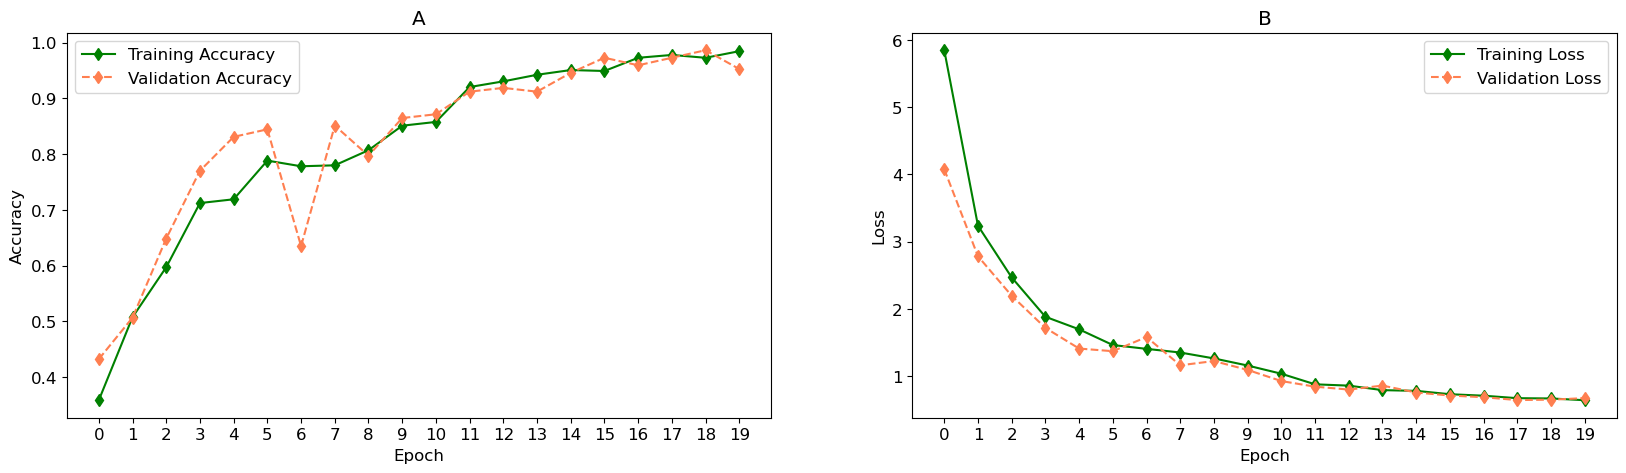

In [51]:
plt.figure(figsize=(20, 5))

plt.rcParams.update({'font.size': 12})

plt.subplot(1, 2, 1)
plt.plot(final_acc, 'd-', label='Training Accuracy', color='green')
plt.plot(final_val_acc, 'd--', label='Validation Accuracy', color='coral')
plt.xticks(np.arange(0, 20, 1))
#plt.title('Training Metrics at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('A')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_loss, 'd-', label='Training Loss', color='green')
plt.plot(final_val_loss, 'd--', label='Validation Loss', color='coral')
plt.xticks(np.arange(0, 20, 1))
#plt.title('Validation Metrics at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('B')
plt.legend()
plt.savefig("training_graph.png", dpi = 600)
plt.show()


In [56]:
#saving the accuracy and loss in .npy, np.load function is used

np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/final_acc.npy', final_acc)


In [57]:
np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/final_val_acc.npy', final_val_acc)

In [58]:
np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/final_loss.npy', final_loss)

In [59]:
np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/final_val_loss.npy', final_val_loss)

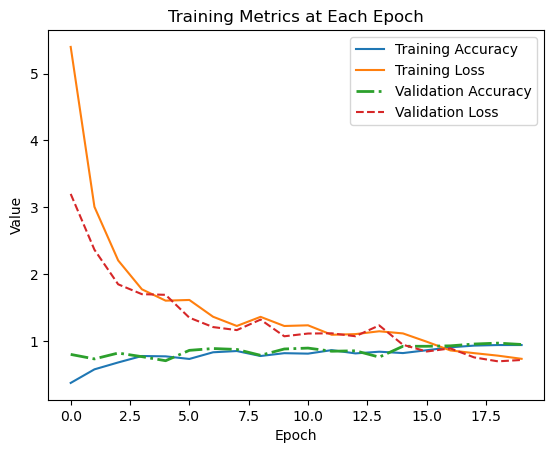

In [172]:
plt.plot(final_acc, label='Training Accuracy')
plt.plot(final_loss, label='Training Loss')
plt.plot(final_val_acc, '-.', label='Validation Accuracy', linewidth=2)
plt.plot(final_val_loss, '--', label='Validation Loss')
plt.title('Training Metrics at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [33]:
# Extract the metrics from the callback of Conv+Dense Layer Training
batch_accuracies_conv = batch_metrics_callback.batch_accuracies
batch_losses_conv = batch_metrics_callback.batch_losses
validation_accuracies_conv = batch_metrics_callback.validation_accuracies
validation_losses_conv = batch_metrics_callback.validation_losses

In [34]:
final_batch_acc = batch_accuracies_dense
final_batch_loss = batch_losses_dense
final_val_acc = validation_accuracies_dense
final_val_loss = validation_losses_dense

In [35]:
final_batch_acc.extend(batch_accuracies_conv)
final_batch_loss.extend(batch_losses_conv)
final_val_acc.extend(validation_accuracies_conv)
final_val_loss.extend(validation_losses_conv)

In [63]:
len(final_batch_acc)

600

In [74]:
max(final_val_loss)

3.198496103286743

In [38]:
score = model.evaluate(X_val, Y_val, verbose=1)

6/6 [==============================] - 3s 434ms/step - loss: 0.6299 - accuracy: 0.9838


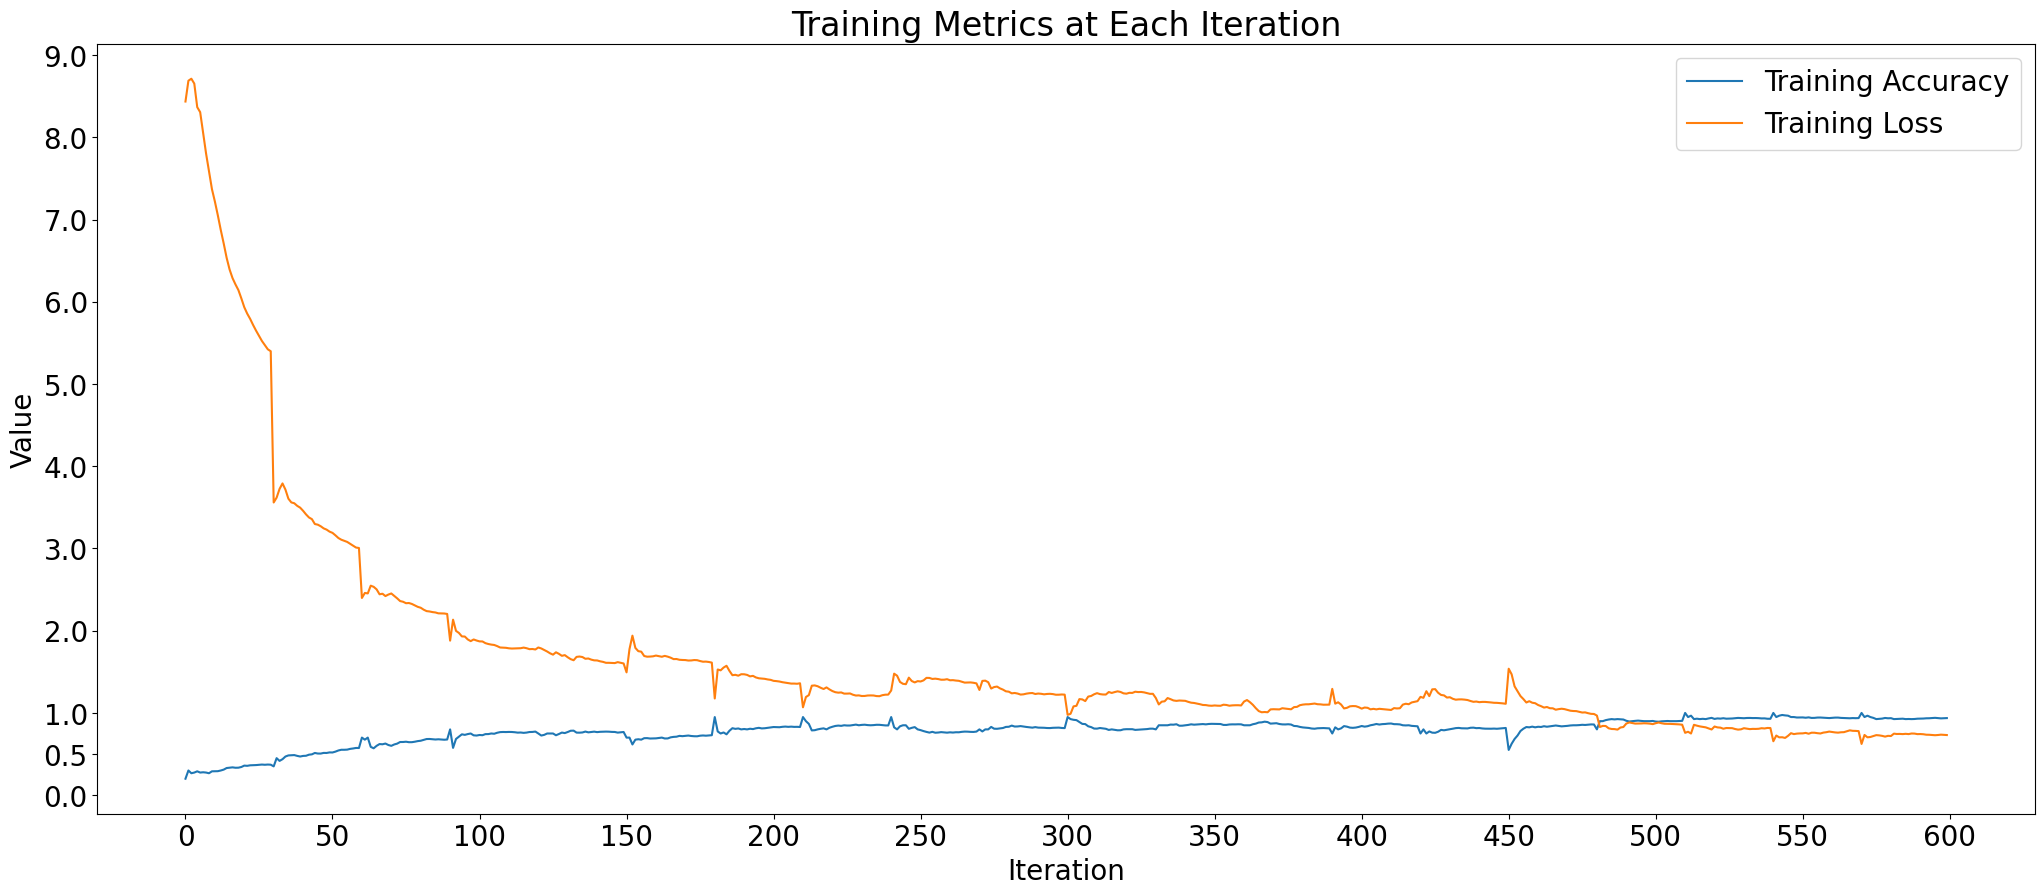

In [94]:
#ploting the accuracy and loss of training
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(25, 10))
plt.plot(final_batch_acc, label='Training Accuracy')
plt.plot(final_batch_loss, label='Training Loss')
plt.yticks([0,0.5,1,2,3,4,5,6,7,8,9])
plt.xticks(np.arange(0, 650, 50))
plt.title('Training Metrics at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.savefig("training_acc_loss.png", dpi = 600)
plt.show()


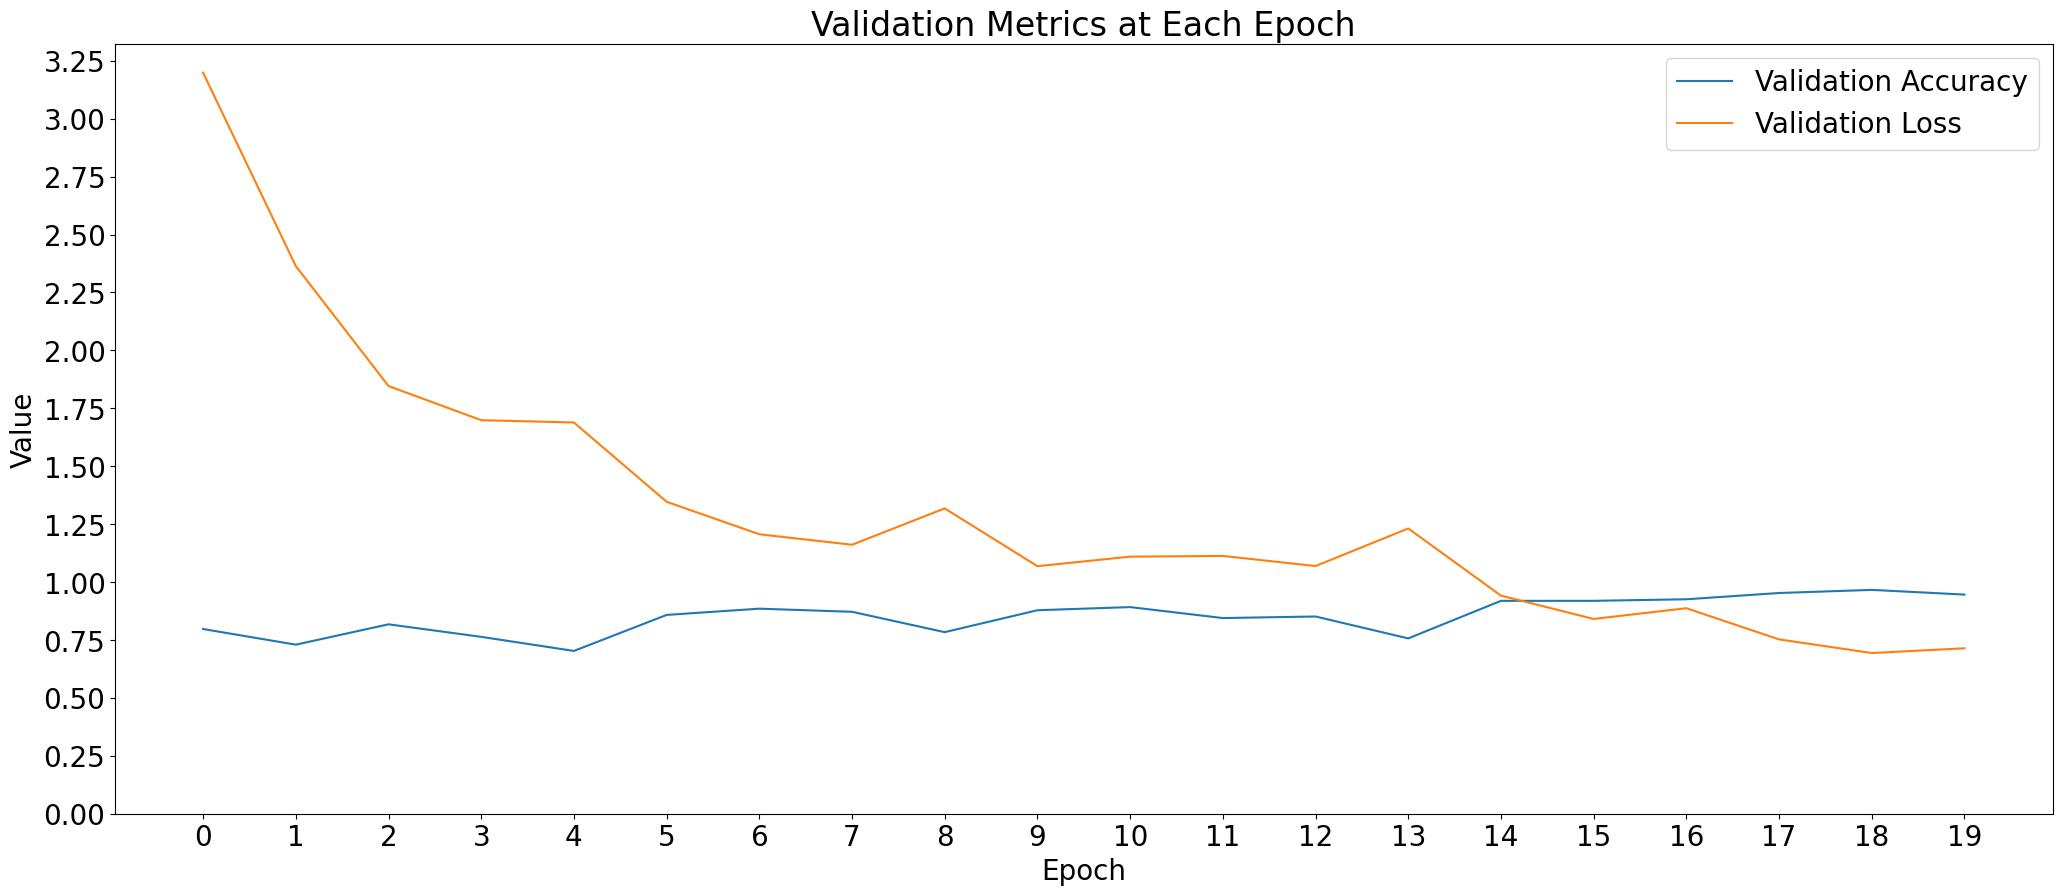

In [104]:
#ploting the validation accuracy and validation loss of training
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(25, 10))
plt.plot(final_val_acc, label='Validation Accuracy')
plt.plot(final_val_loss, label='Validation Loss')
plt.yticks(np.arange(0, 3.5, 0.25))
plt.xticks(np.arange(0, 20, 1))
plt.title('Validation Metrics at Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.savefig("train_validation.png", dpi = 600)
plt.show()


6/6 [==============================] - 3s 404ms/step


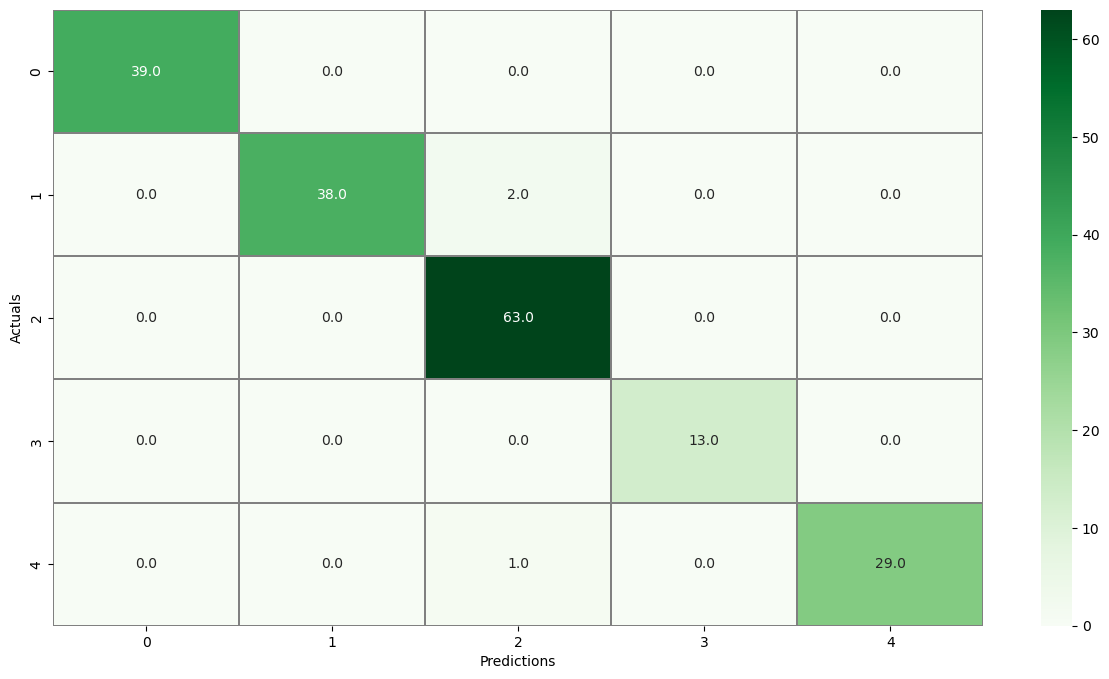

In [39]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = Y_val


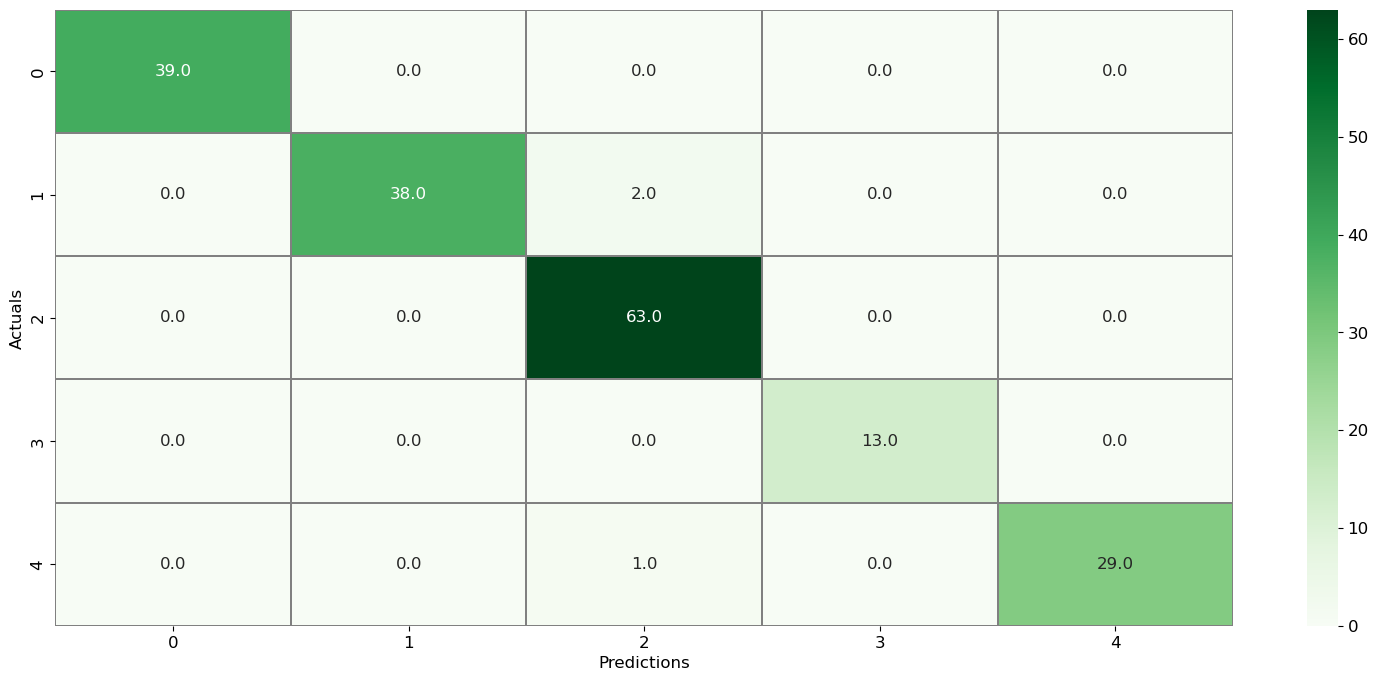

In [48]:
plt.rcParams.update({'font.size': 12})
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
f,ax = plt.subplots(figsize=(19, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.savefig("confusion_matrix.png", dpi = 600)

In [52]:
len(Y_val)


185

In [60]:
np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/y_pred_classes.npy', y_pred_classes)


In [61]:
np.save('/Users/aryansmac/Documents/PROJECT/TEEP/Biometric_Authentication/Aryan_work/Metrices/y_true.npy', y_true)


In [ ]:
#CLASS 0: TP-39, FP-0, FN-0 ------ PRECISION:100%, RECALL:100%
#CLASS 1: TP-38, FP-0, FN-2 ------ PRECISION:100%, RECALL:95%
#CLASS 2: TP-63, FP-3, FN-0 ------ PRECISION:95.4545%, RECALL:100%
#CLASS 3: TP-13, FP-0, FN-0 ------ PRECISION:100%, RECALL:100%
#CLASS 4: TP-29, FP-0, FN-1 ------ PRECISION:100%, RECALL:96.6667%

#TOTAL TP:182, FP:3, FN:3

#MACRO-PRECISION: 99.0909%
#MACRO-RECALL: 98.3333%
#F1-SCORE: 98.7121%
#ACCURACY = 98.3784%

In [123]:

#base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False)
img = tf.keras.layers.Input(shape=(224, 224, 3))
x = vgg16_base(img)
x=tf.keras.layers.Flatten()(x)
y = tf.keras.layers.Dense(256, activation='relu')(x)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y=tf.keras.layers.Dense(5,activation='softmax')(y)
model_v2 = tf.keras.Model(inputs=[img], outputs=y)
model_v2.summary()
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 5)                 645 

In [124]:
model.compile(optimizer='adam', 
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])

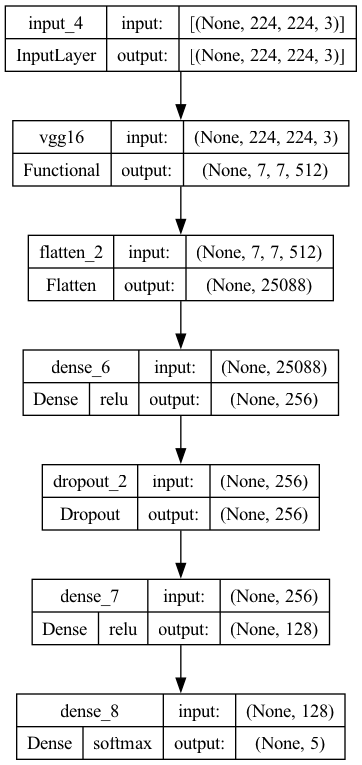

In [126]:
tf.keras.utils.plot_model(model_v2, to_file = "graph.png", show_shapes=True, show_dtype=False, show_layer_names=True
                         , expand_nested=False, show_layer_activations=True)

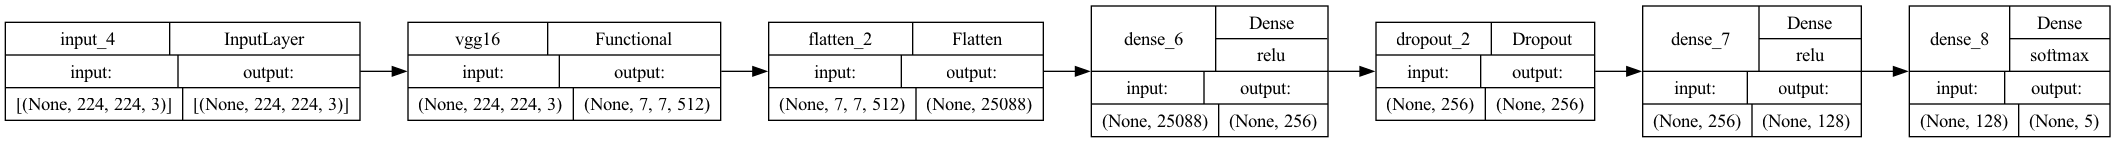

In [128]:
tf.keras.utils.plot_model(model_v2, to_file = "graph_hr.png", show_shapes=True, show_dtype=False, show_layer_names=True
                         , expand_nested=False, show_layer_activations=True, rankdir='LR')

In [129]:
# testing on untrained faces
test_img = cv2.imread("cropped_face7.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (224, 224), interpolation=cv2.INTER_AREA)

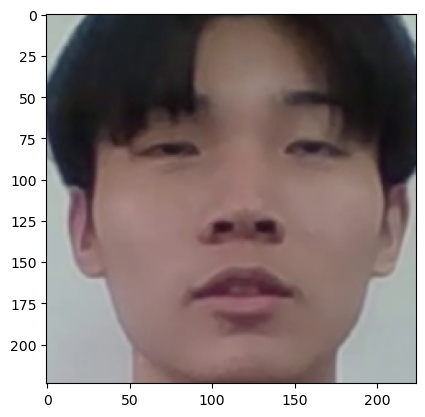

In [45]:
plt.imshow(test_img)
plt.show()

In [46]:
test_img = np.array([test_img])

In [47]:
test_pred = model.predict(test_img)

1/1 [==============================] - 0s 23ms/step


In [48]:
test_pred

array([[0.5825661 , 0.3483281 , 0.05439515, 0.01158464, 0.00312603]],
      dtype=float32)

In [49]:
scaled_logits = test_pred / 1.5

In [50]:
softmax_scores = tf.nn.softmax(scaled_logits).numpy()

In [51]:
softmax_scores

array([[0.2549974 , 0.21813077, 0.17931417, 0.17426883, 0.17328887]],
      dtype=float32)